# 📊 Trader Behavior vs Market Sentiment  
### Bitcoin Fear & Greed Index × Hyperliquid Trading Data

**Candidate:** Sumit  
**Role Applied:** Data Science

---

## 🔍 Introduction

Financial markets are heavily influenced by investor psychology, particularly during periods of extreme **fear** and **greed**. Understanding how trader behavior changes across different sentiment regimes can provide valuable insights into profitability, risk management, and strategy design.

In this notebook, I analyze the relationship between **Bitcoin market sentiment (Fear vs Greed)** and **trader performance on Hyperliquid**, focusing on:

- Profitability (Closed PnL)
- Risk-taking behavior (leverage, position size)
- Trading activity and win rates

The objective is to uncover **hidden behavioral patterns** and derive **actionable insights** that can inform smarter trading strategies in Web3 markets.

---



In [2]:
import pandas as pd

# Load historical trading data and market sentiment index from CSV files.
trades = pd.read_csv("/content/drive/MyDrive/historical_data.csv")
sentiment = pd.read_csv("/content/drive/MyDrive/fear_greed_index.csv")

In [3]:
# Display the dimensions of the trades and sentiment datasets.
print(trades.shape)
print(sentiment.shape)

# Show key statistics for 'Closed PnL' to understand profit/loss distribution.
trades['Closed PnL'].describe()

(211224, 16)
(2644, 4)


,Closed PnL
count,211224.000000
mean,48.749001
std,919.164828
min,-117990.104100
25%,0.000000
50%,0.000000
75%,5.792797
max,135329.090100


## Overall Trade Outcome Distribution

Before incorporating market sentiment, we first examine the **baseline distribution of profitable vs loss-making trades** across the entire dataset.

This provides a high-level understanding of:
- Overall trader profitability
- Whether the dataset is dominated by winning or losing trades

📌 This baseline will later be compared against **Fear vs Greed** sentiment regimes to evaluate how market psychology impacts trading outcomes.


<Axes: ylabel='count'>

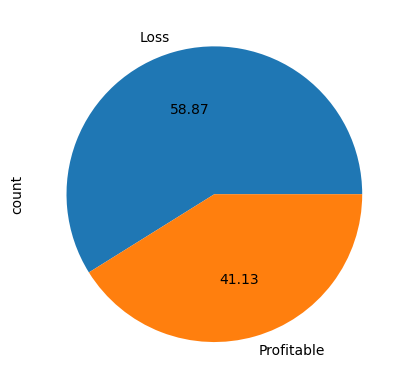

In [4]:
# Classify trades as 'Profitable' or 'Loss' based on 'Closed PnL' > 0.
# Then, visualize the distribution of these trade outcomes using a pie chart.
(trades['Closed PnL'] > 0) \
    .map({True: 'Profitable', False: 'Loss'}) \
    .value_counts().plot(kind='pie',autopct='%.2f')

In [5]:
import pandas as pd

# Convert 'Timestamp IST' to a consistent date format, handling potential errors.
trades['date'] = pd.to_datetime(
    trades['Timestamp IST'],
    dayfirst=True,
    errors='coerce'
).dt.date

# Convert Unix 'timestamp' to a date format for the sentiment data.
sentiment['date'] = pd.to_datetime(
    sentiment['timestamp'],
    unit='s'
).dt.date

In [6]:
# Merge trade data with sentiment data based on 'date' using a left join.
# This aligns each trade with the market sentiment on that specific day.
merged = pd.merge(
    trades[['date', 'Closed PnL','Coin','Direction']],
    sentiment[['date', 'classification']],
    on='date',
    how='left'
)

## Top 5 Coins by Total Profit

This chart shows the **top 5 traded coins ranked by total realized profit (Closed PnL)** across all trades.

It highlights where traders generated the most absolute profits and provides context for deeper analysis of **risk, volume, and sentiment-driven performance** in later sections.


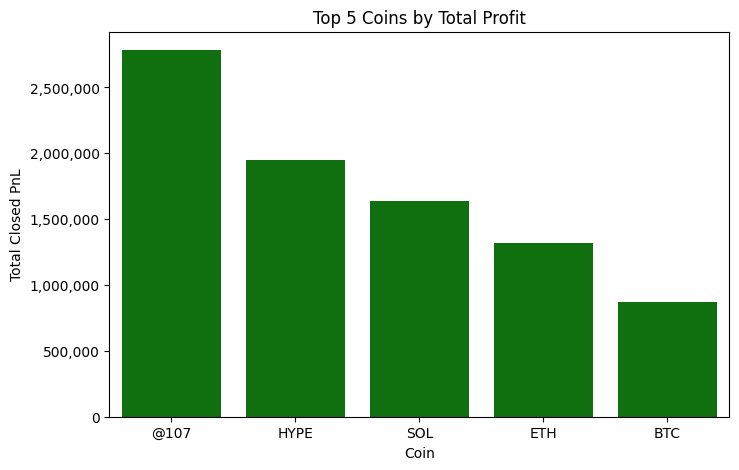

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Calculate total profit per coin and identify the top 5 most profitable.
top5_coins = (
    trades
    .groupby('Coin', as_index=False)['Closed PnL']
    .sum()
    .sort_values(by='Closed PnL', ascending=False)
    .head(5)
)
pd.options.display.float_format = '{:,.2f}'.format # Apply consistent number formatting for DataFrame display.

plt.figure(figsize=(8,5))
# Generate a bar plot to visualize the top 5 coins by total profit.
ax = sns.barplot(data=top5_coins, x='Coin', y='Closed PnL',color='g')

# Format y-axis labels for readability.
ax.yaxis.set_major_formatter(
    FuncFormatter(lambda x, _: f'{x:,.0f}')
)

ax.set_title('Top 5 Coins by Total Profit')
ax.set_ylabel('Total Closed PnL')
ax.set_xlabel('Coin')

plt.show()

## Top 5 Coins by Total Loss

This chart highlights the **five coins with the highest cumulative losses (Closed PnL)** across all trades.

Analyzing loss-heavy assets helps identify **risk concentration** and assets where traders consistently underperform.


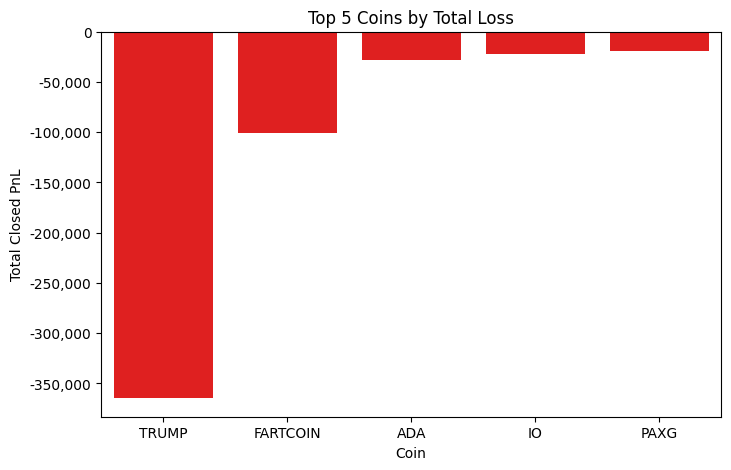

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Calculate total loss per coin and identify the top 5 coins with the largest losses.
top5_loss_coins = (
    trades
    .groupby('Coin', as_index=False)['Closed PnL']
    .sum()
    .sort_values(by='Closed PnL', ascending=True)
    .head(5)
)
pd.options.display.float_format = '{:,.2f}'.format
top5_loss_coins # Display the identified loss-making coins.

plt.figure(figsize=(8,5))
# Generate a bar plot to visualize the top 5 coins by total loss.
ax = sns.barplot(data=top5_loss_coins, x='Coin', y='Closed PnL',color='r')

# Format y-axis labels for readability.
ax.yaxis.set_major_formatter(
    FuncFormatter(lambda x, _: f'{x:,.0f}')
)

ax.set_title('Top 5 Coins by Total Loss')
ax.set_ylabel('Total Closed PnL')
ax.set_xlabel('Coin')

plt.show()

In [9]:
# Aggregate 'Closed PnL' by market sentiment and coin to find profitability.
coin_classification_pnl = (
    merged
    .groupby(['classification', 'Coin'])['Closed PnL']
    .sum()
    .reset_index()
)

# Identify the coin with the highest profit for each market sentiment classification.
max_profit_per_class = (
    coin_classification_pnl
    .loc[
        coin_classification_pnl
        .groupby('classification')['Closed PnL']
        .idxmax()
    ]
    .sort_values('classification')
)

max_profit_per_class

,classification,Coin,Closed PnL
41,Extreme Fear,HYPE,"482,083.81"
88,Extreme Greed,@107,"1,988,618.87"
324,Fear,HYPE,"840,306.35"
387,Greed,@107,"724,342.31"
694,Neutral,SOL,"303,376.19"


## Profit by Coin Across Market Sentiment

This chart compares **coin-level profitability** across different **market sentiment classifications (Fear vs Greed)**.

It helps assess whether certain assets perform better under specific sentiment regimes and whether profitability is sentiment-dependent.


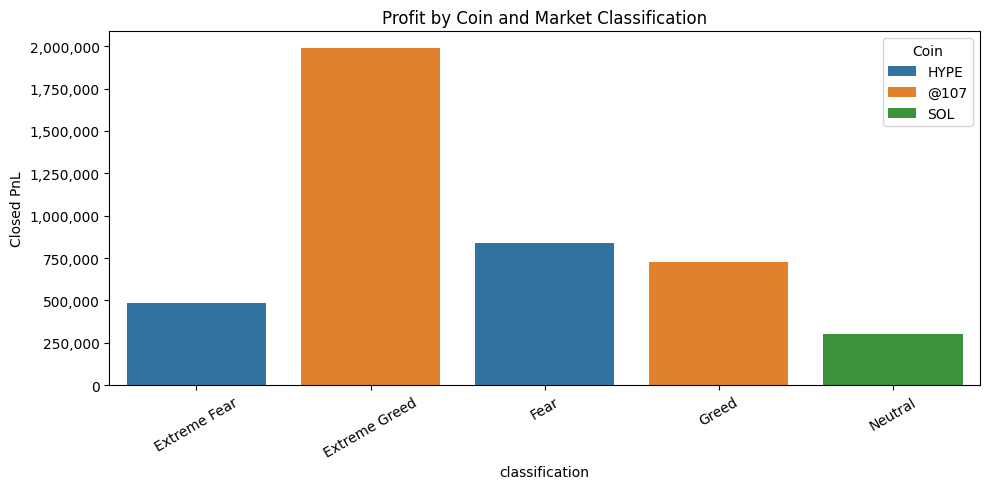

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

plt.figure(figsize=(10,5))
# Plot profit by coin across different market sentiment classifications.
ax = sns.barplot(
    data=max_profit_per_class,
    x='classification',
    y='Closed PnL',
    hue='Coin'
)

# Format y-axis labels and adjust layout for clarity.
ax.yaxis.set_major_formatter(
    FuncFormatter(lambda x, _: f'{x:,.0f}')
)
plt.title('Profit by Coin and Market Classification')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

## Maximum Loss by Coin Across Market Sentiment

This chart shows the **worst-performing coin (maximum loss)** within each **market sentiment classification**.

It highlights how downside risk varies across assets depending on whether the market is driven by Fear or Greed.


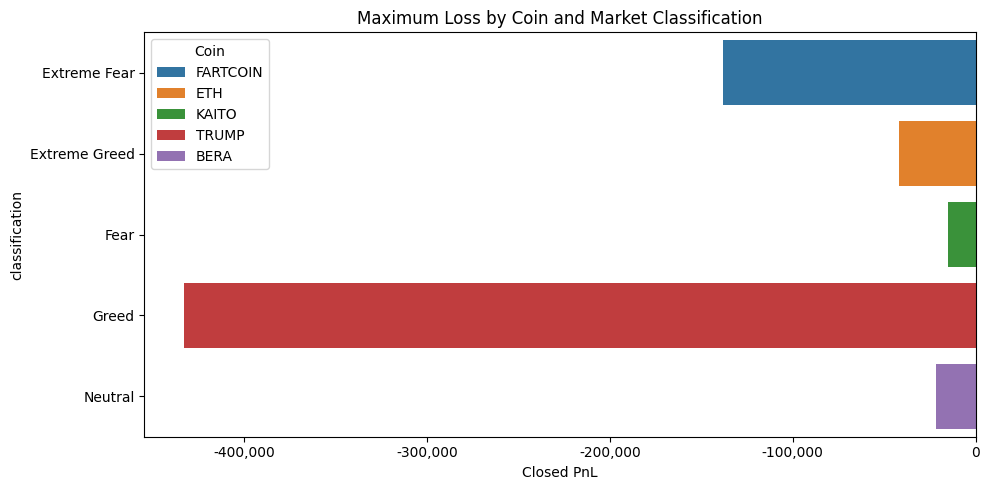

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Identify the coin with the largest loss for each market sentiment classification.
max_loss_per_class = (
    coin_classification_pnl
    .loc[
        coin_classification_pnl
        .groupby('classification')['Closed PnL']
        .idxmin()
    ]
    .sort_values('classification')
)

plt.figure(figsize=(10,5))
# Plot maximum loss by coin across different market sentiment classifications.
ax = sns.barplot(
    data=max_loss_per_class,
    y='classification',
    x='Closed PnL',
    hue='Coin',
    orient='h'
)

# Format x-axis labels and adjust layout for clarity.
ax.xaxis.set_major_formatter(
    FuncFormatter(lambda x, _: f'{x:,.0f}')
)
plt.title('Maximum Loss by Coin and Market Classification')
plt.tight_layout()
plt.show()

In [12]:
# Isolate trades for the 'TRUMP' coin.
trump_trades = merged[trades['Coin'] == 'TRUMP']

# Calculate total profit for TRUMP trades, categorized by market sentiment.
trump_profit_by_class = (
    trump_trades[trump_trades['Closed PnL'] > 0]
    .groupby('classification')['Closed PnL']
    .sum()
    .reset_index()
    .sort_values('Closed PnL', ascending=False)
)
trump_profit_by_class

,classification,Closed PnL
0,Extreme Fear,"31,639.22"
2,Fear,"22,455.31"
1,Extreme Greed,"22,233.71"
4,Neutral,"20,121.15"
3,Greed,"5,586.27"


## Case Study: TRUMP Coin Profitability by Market Sentiment

This chart analyzes **TRUMP coin profitability** across different **market sentiment classifications**.

By isolating a single asset, we can better observe how sentiment impacts performance without broader market noise.


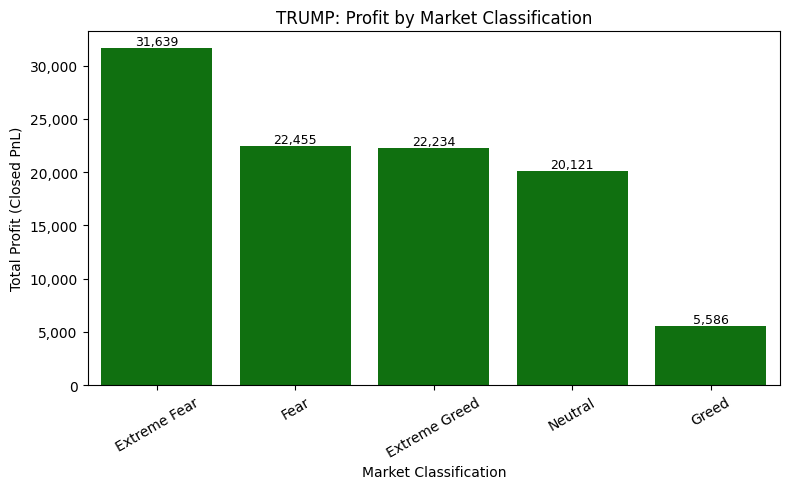

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

plt.figure(figsize=(8,5))

# Plot TRUMP coin's total profit by market sentiment classification.
ax = sns.barplot(
    data=trump_profit_by_class,
    x='classification',
    y='Closed PnL',color='g'
)

# Format y-axis labels and add profit values as annotations.
ax.yaxis.set_major_formatter(
    FuncFormatter(lambda x, _: f'{x:,.0f}')
)

plt.title('TRUMP: Profit by Market Classification')
plt.xlabel('Market Classification')
plt.ylabel('Total Profit (Closed PnL)')
plt.xticks(rotation=30)

for p in ax.patches:
    ax.annotate(
        f'{p.get_height():,.0f}',
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center', va='bottom', fontsize=9
    )

plt.tight_layout()
plt.show()

In [14]:
# Isolate trades for the '@107' coin.
ONE7_trades = merged[trades['Coin'] == '@107']

# Calculate total loss for ONE7 trades, categorized by market sentiment.
ONE7_loss_by_class = (
    ONE7_trades[ONE7_trades['Closed PnL'] < 0]
    .groupby('classification')['Closed PnL']
    .sum()
    .reset_index()
    .sort_values('Closed PnL', ascending=False)
)
ONE7_loss_by_class

,classification,Closed PnL
4,Neutral,"-17,297.82"
1,Extreme Greed,"-22,476.76"
2,Fear,"-70,245.43"
3,Greed,"-129,903.06"
0,Extreme Fear,"-151,607.04"


## Case Study: ONE7 Coin Losses by Market Sentiment

This chart focuses on **ONE7**, an asset that shows **significant cumulative losses**, analyzed across different **market sentiment classifications**.

The goal is to understand whether losses are **sentiment-driven** or persistent across market conditions.


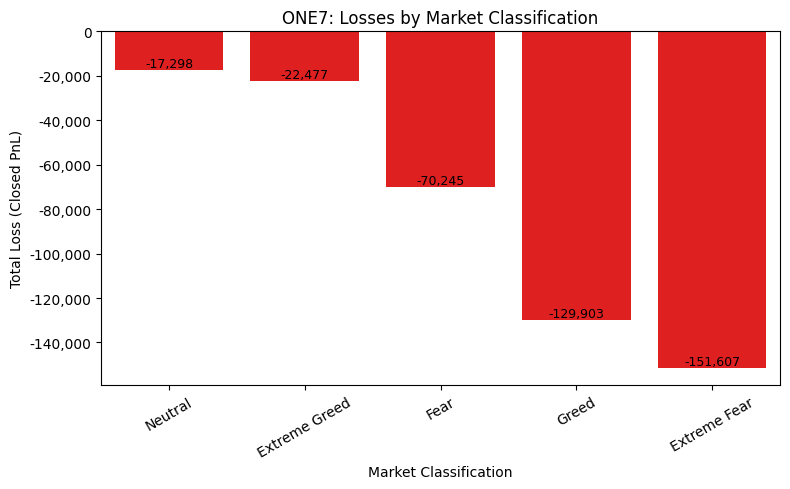

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

plt.figure(figsize=(8,5))

# Plot ONE7 coin's total loss by market sentiment classification.
ax = sns.barplot(
    data=ONE7_loss_by_class,
    x='classification',
    y='Closed PnL',color='r'
)

# Format y-axis labels and add loss values as annotations.
ax.yaxis.set_major_formatter(
    FuncFormatter(lambda x, _: f'{x:,.0f}')
)

plt.title('ONE7: Losses by Market Classification')
plt.xlabel('Market Classification')
plt.ylabel('Total Loss (Closed PnL)')
plt.xticks(rotation=30)

for p in ax.patches:
    ax.annotate(
        f'{p.get_height():,.0f}',
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center', va='bottom', fontsize=9
    )

plt.tight_layout()
plt.show()

In [16]:
# Aggregate 'Closed PnL' by coin and trade direction (Long/Short).
coin_direction_pnl = (
    trades
    .groupby(['Coin', 'Direction'])['Closed PnL']
    .sum()
    .reset_index()
)

## Directional Impact on Coin-Level Profitability

This chart highlights the **top coin–direction (Long/Short) combinations** ranked by absolute PnL impact.

It helps identify whether profitability is driven by **directional bias** rather than the asset alone.


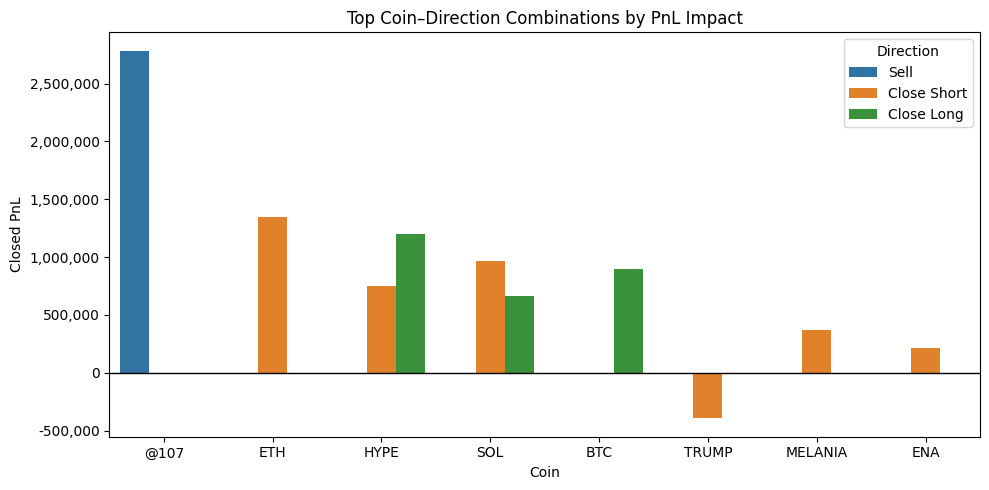

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Identify the top 10 coin-direction combinations with the highest absolute PnL impact.
top_cd = (
    coin_direction_pnl
    .assign(abs_pnl=lambda x: x['Closed PnL'].abs())
    .sort_values('abs_pnl', ascending=False)
    .head(10)
)

plt.figure(figsize=(10,5))
# Plot the PnL for top coin-direction combinations, distinguishing by 'Direction'.
ax = sns.barplot(
    data=top_cd,
    x='Coin',
    y='Closed PnL',
    hue='Direction'
)

# Add a zero line and format y-axis for clarity.
ax.axhline(0, color='black', linewidth=1)
ax.yaxis.set_major_formatter(
    FuncFormatter(lambda x, _: f'{x:,.0f}')
)

plt.title('Top Coin–Direction Combinations by PnL Impact')
plt.tight_layout()
plt.show()

In [18]:
# Identify the top profitable and top loss-making coins.
coin_total_pnl = (
    merged
    .groupby('Coin')['Closed PnL']
    .sum()
    .sort_values(ascending=False)
)
top_profit_coin = coin_total_pnl.index[0]
top_loss_coin = coin_total_pnl.index[-1]
top_profit_coin, top_loss_coin

# Filter data for these focus coins and extract the year.
focus_coins = [top_profit_coin, top_loss_coin]
coin_focus = merged[
    merged['Coin'].isin(focus_coins)
].copy()
coin_focus['Year'] = pd.to_datetime(coin_focus['date']).dt.year

# Aggregate PnL for focus coins by year, direction, and sentiment classification.
year_dir_class = (
    coin_focus
    .groupby(['Coin', 'Year', 'Direction', 'classification'])['Closed PnL']
    .sum()
    .reset_index()
)

In [19]:
# Aggregate PnL by trade direction and market sentiment.
direction_class_pnl = (
    merged
    .groupby(['Direction', 'classification'])['Closed PnL']
    .sum()
    .reset_index()
)

# Reshape data into a matrix (pivot table) for heatmap visualization.
heatmap_data = direction_class_pnl.pivot(
    index='Direction',
    columns='classification',
    values='Closed PnL'
).fillna(0)

## Directional Performance Across Market Sentiment

This heatmap summarizes **profit and loss by trade direction (Long vs Short)** across different **market sentiment classifications**.

It provides a compact view of how directional strategies perform under varying psychological market conditions.


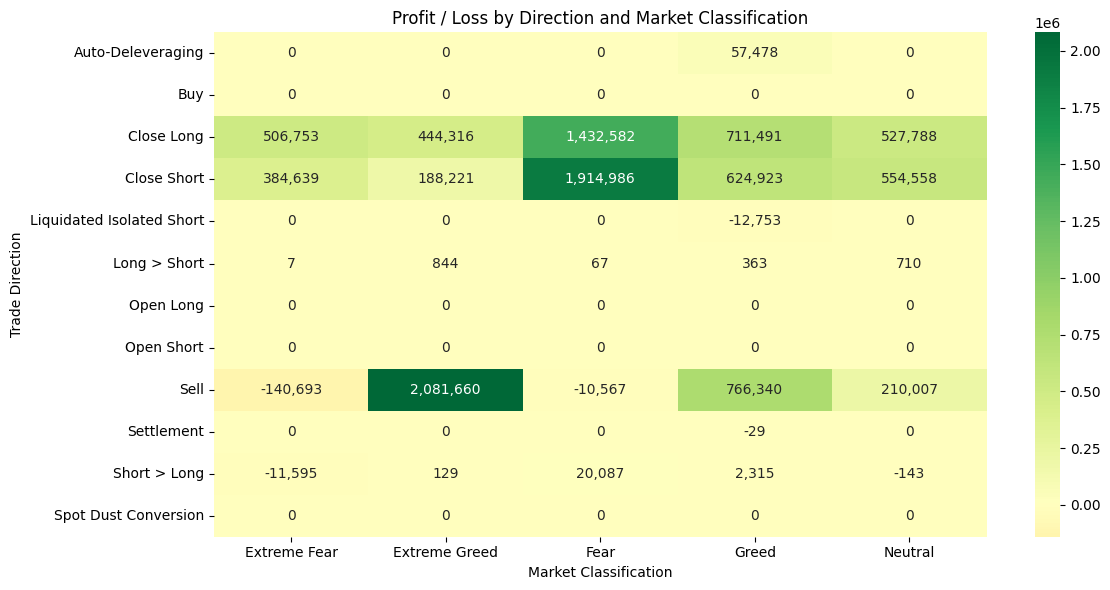

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))

# Generate a heatmap to visualize Profit/Loss by trade direction and market sentiment.
# Colors are set to show losses (red) and profits (green), centered around zero.
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=',.0f',
    cmap='RdYlGn',
    center=0
)

plt.title('Profit / Loss by Direction and Market Classification')
plt.xlabel('Market Classification')
plt.ylabel('Trade Direction')
plt.tight_layout()
plt.show()

In [21]:
# Map sentiment classifications to numerical scores for potential ordering or analysis.
sentiment_map = {
    'Extreme Fear': -2,
    'Fear': -1,
    'Neutral': 0,
    'Greed': 1,
    'Extreme Greed': 2
}
merged['sentiment_score'] = merged['classification'].map(sentiment_map)

# Convert 'date' to datetime and extract the 'Year'.
merged['date'] = pd.to_datetime(merged['date'])
merged['Year'] = merged['date'].dt.year

# Aggregate PnL by year, sentiment classification, and sentiment score.
yearly_sentiment_pnl = (
    merged
    .groupby(['Year', 'classification', 'sentiment_score'])['Closed PnL']
    .sum()
    .reset_index()
)

## Year-wise Profitability by Market Sentiment

This chart shows **annual aggregated profit and loss**, split by **market sentiment classification (Fear vs Greed)**.

It helps evaluate whether the impact of sentiment on trader performance is **consistent over time** or regime-specific.


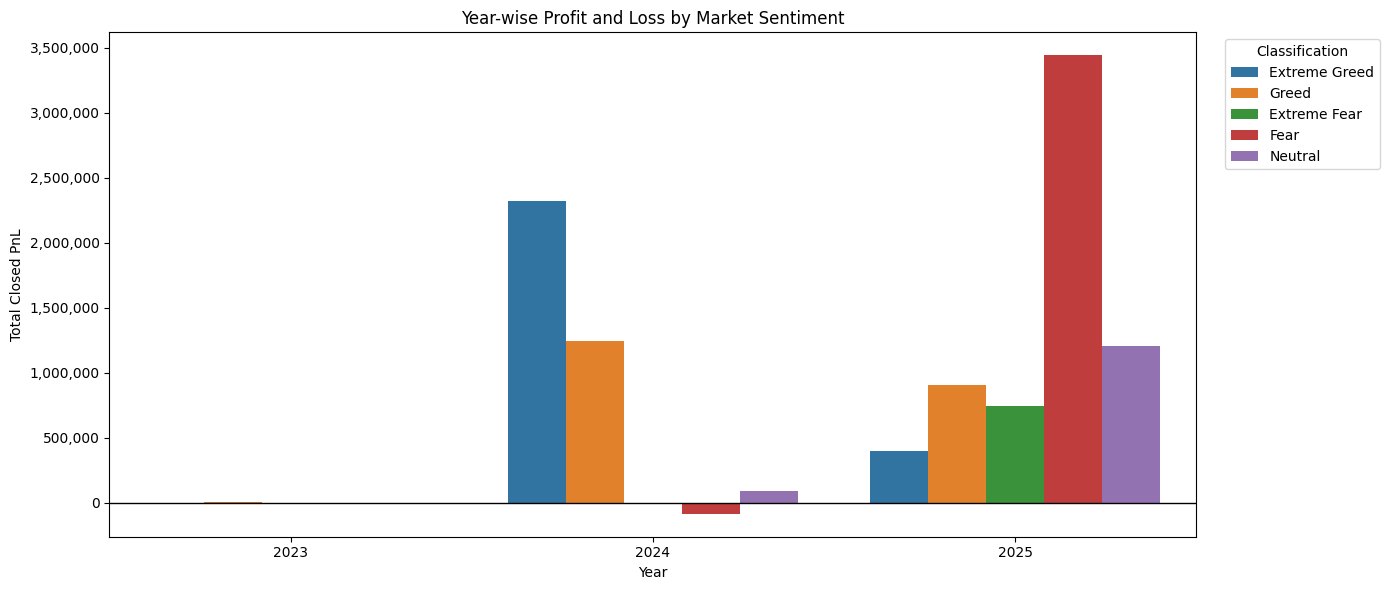

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

plt.figure(figsize=(14,6))

# Plot year-wise total PnL, segmented by market sentiment classification.
ax = sns.barplot(
    data=yearly_sentiment_pnl,
    x='Year',
    y='Closed PnL',
    hue='classification'
)

# Add a zero line, format y-axis, and adjust legend for clarity.
ax.axhline(0, color='black', linewidth=1)
ax.yaxis.set_major_formatter(
    FuncFormatter(lambda x, _: f'{x:,.0f}')
)
plt.title('Year-wise Profit and Loss by Market Sentiment')
plt.xlabel('Year')
plt.ylabel('Total Closed PnL')
plt.legend(title='Classification', bbox_to_anchor=(1.02, 1))
plt.tight_layout()
plt.show()

In [31]:
import numpy as np
import pandas as pd

# Calculate total profit, win rate, volatility, and trade count for each coin.
coin_consistency = (
    merged
    .groupby('Coin')['Closed PnL']
    .agg(
        total_profit='sum',                         # total PnL
        win_rate=lambda x: (x > 0).mean(),          # % winning trades
        volatility='std',                           # risk (PnL std dev)
        trade_count='count'                         # total number of trades
    )
    .reset_index()
)

# Compute 'Average PnL per Trade'
coin_consistency['average_pnl_per_trade'] = coin_consistency['total_profit'] / coin_consistency['trade_count']

# Compute a 'consistency_score' as (total_profit * win_rate) / volatility.
# This score helps evaluate a coin's performance and risk-adjusted returns.
coin_consistency['consistency_score'] = (
    coin_consistency['total_profit'] *
    coin_consistency['win_rate'] /
    coin_consistency['volatility']
)

# Handle potential infinite values and NaNs in the consistency score, then sort.
coin_consistency = coin_consistency.replace([np.inf, -np.inf], np.nan)
coin_consistency = coin_consistency.dropna(subset=['consistency_score'])
coin_consistency = coin_consistency.sort_values(
    'consistency_score',
    ascending=False
)

# Assign a rank to each coin based on its consistency score.
coin_consistency['rank'] = (
    coin_consistency['consistency_score']
    .rank(method='dense', ascending=False)
    .astype(int)
)

# Save the results to a CSV file.
coin_consistency.to_csv(
    'coin_consistency_score.csv',
    index=False
)

In [32]:
# Display the calculated coin consistency scores.
coin_consistency

,Coin,total_profit,win_rate,volatility,trade_count,average_pnl_per_trade,consistency_score,rank
137,HYPE,"1,948,484.60",0.41,406.67,68005,28.65,"1,988.38",1
4,@107,"2,783,912.92",0.47,"1,016.16",29992,92.82,"1,281.03",2
105,BTC,"868,044.73",0.35,526.32,26064,33.30,578.62,3
205,SOL,"1,639,555.93",0.39,"1,423.43",10691,153.36,454.55,4
161,MELANIA,"390,351.07",0.44,436.61,4428,88.16,396.95,5
...,...,...,...,...,...,...,...,...
188,POPCAT,"-7,922.18",0.15,46.20,1152,-6.88,-25.30,187
79,ADA,"-28,113.46",0.27,287.89,581,-48.39,-26.22,188
181,PAXG,"-18,688.87",0.16,79.08,1265,-14.77,-38.67,189
217,TRUMP,"-364,824.91",0.35,"2,515.52",1920,-190.01,-50.68,190


In [33]:
# Save the top 10 coins by consistency score to a CSV file.
coin_consistency.head(10).to_csv(
    'top_10_coin_consistency.csv',
    index=False
)

# Display the top 10 coins by consistency score.
coin_consistency.head(10)

,Coin,total_profit,win_rate,volatility,trade_count,average_pnl_per_trade,consistency_score,rank
137,HYPE,"1,948,484.60",0.41,406.67,68005,28.65,"1,988.38",1
4,@107,"2,783,912.92",0.47,"1,016.16",29992,92.82,"1,281.03",2
105,BTC,"868,044.73",0.35,526.32,26064,33.30,578.62,3
205,SOL,"1,639,555.93",0.39,"1,423.43",10691,153.36,454.55,4
161,MELANIA,"390,351.07",0.44,436.61,4428,88.16,396.95,5
23,@151,"11,583.84",0.92,37.50,324,35.75,283.14,6
236,ZEREBRO,"21,166.93",0.80,81.23,769,27.53,209.75,7
146,JELLY,"35,193.72",0.81,138.76,992,35.48,205.30,8
176,OGN,"1,752.67",1.00,9.08,258,6.79,192.22,9
120,ETH,"1,319,978.84",0.36,"2,741.76",11158,118.30,173.28,10
